Porjet P2 (suite du P1

Vous êtes nouvel embauche chez CoolCorp, une startup qui spécialise
dans l'analyse des désastres maritimes.  Un nouveau client, White Star
Lines, se trouve face à un procès à travers le temps, affaire délicat.
Votre chef vous demande, en tant que seul data scientist chez
CoolCorp, d'analyser les données `*.csv`.  WSL a déjà engagé un expert
pour annoter une partie des données (`test.csv`) avec la survie ou pas
des passagers.

Le chef comprend que vous êtes nouveau, c'est pourquoi il vous laisse
une semaine complète pour cette analyse.

J'ouvre les fichiers train et test

In [1]:
import csv as csv 
import numpy as np
import pandas as pd

datap = pd.read_csv('train.csv', header=0)
testp = pd.read_csv('test.csv', header=0)

la ligne de commande suivante détail les premiéres élément de train.csv

<b>Nettayage des données</b> 

Nettayage des données ci-dessous pour permettre des analyses plus poussée et enlevée les données non approprié
exemple:
    -des valeurs à null.
    -des colonnes en type string qui peuvent être numérisé (le sexe par exemple).

Nettayage des données: remplacer le sexe par le numerisation en 0 et 1 (booléan)

In [2]:
# Ajouter une colonne :
datap['Gender'] = 4
testp['Gender'] = 4

# Peut-être avec des valeurs plus intéressantes :
datap['Gender'] = datap['Sex'].map( lambda x: x[0].upper() )
testp['Gender'] = testp['Sex'].map( lambda x: x[0].upper() )

# Ou binaire :
datap['Gender'] = datap['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
testp['Gender'] = testp['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

Nettayage des données: remplacer les ages null par l'age mediane selon le genre et la class.

In [3]:
#nettoyage de donnée de datap et testp
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = datap[(datap['Gender'] == i) & \
                              (datap['Pclass'] == j+1)]['Age'].dropna().median()
median_ages

median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = testp[(testp['Gender'] == i) & \
                              (testp['Pclass'] == j+1)]['Age'].dropna().median()
median_ages

array([[ 41.,  24.,  22.],
       [ 42.,  28.,  24.]])

on ajoute les ages dans la nouvelle colonne AgeFill puis on affiche les dix premiére 

In [4]:
datap['AgeFill'] = datap['Age']
testp['AgeFill'] = testp['Age']

on ajoute les ages medians dans la nouvelle colonne AgeFill, où les ages sont null. Puis on affiche les dix premiéres modifications

In [5]:
# Et puis on le rempli :
for i in range(0, 2):
    for j in range(0, 3):
        datap.loc[ (datap.Age.isnull()) & (datap.Gender == i) & 
                (datap.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]
datap[ datap['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head(10)

# Et puis on le rempli :
for i in range(0, 2):
    for j in range(0, 3):
        testp.loc[ (testp.Age.isnull()) & (testp.Gender == i) & 
                (testp.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]

on convertit la colonne en type integer.

In [6]:
datap['AgeIsNull'] = pd.isnull(datap.Age).astype(int)
testp['AgeIsNull'] = pd.isnull(testp.Age).astype(int)

on crée la colonne FamilySize (taille de la famille) et Age*Class

In [7]:
# parch is number of parents or children on board.
datap['FamilySize'] = datap['SibSp'] + datap['Parch']
testp['FamilySize'] = testp['SibSp'] + testp['Parch']

# Class affected survival.  Maybe age will, too.
# Who knows, maybe the product will be predictive, too.  Let's set it up.
datap['Age*Class'] = datap.AgeFill * datap.Pclass
testp['Age*Class'] = testp.AgeFill * testp.Pclass

ci-dessous, les embarcations S, C et Q deviennent 1, 2, 3 dans une nouvelle colonne

In [40]:
datap['EmbarkedBin'] = datap['Embarked'].map( {'S': 1, 'C': 2, 'Q': 3, None: 1} )
datap['EmbarkedBin'][61]

1

essaie regression logistique

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

# Import some data to play with.
iris = datasets.load_iris()
X = datap[datap['Survived']==1]['EmbarkedBin'][:, :2]  # we only take the first two features.
Y = datap['Survived']

h = .02  # step size in the mesh

logreg = linear_model.LogisticRegression(C=1e5)

# We create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points.
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()


ValueError: Can only tuple-index with a MultiIndex

<b>Analyse de l'influence de l'age selon le tarif</b> 

Ici, on affiche un tableau de l'age selon le tarif(fare)

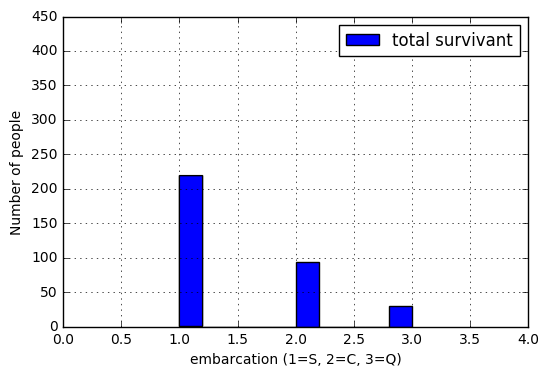

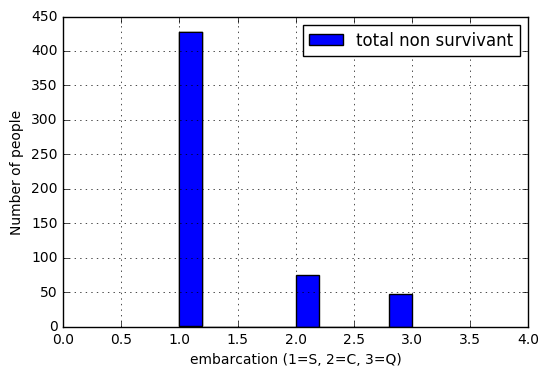

In [44]:
#graphique montrant le tarif selon l'age
import matplotlib.pyplot as plt

plt.hist(datap[datap['Survived']==1]['EmbarkedBin'], label='total survivant')
plt.xlabel('embarcation (1=S, 2=C, 3=Q)')
plt.ylabel('Number of people')
plt.legend(loc='upper right')
plt.axis([0, 4, 0, 450])
plt.grid(True)
plt.show()

plt.hist(datap[datap['Survived']==0]['EmbarkedBin'], label='total non survivant')
plt.xlabel('embarcation (1=S, 2=C, 3=Q)')
plt.ylabel('Number of people')
plt.legend(loc='upper right')
plt.axis([0, 4, 0, 450])
plt.grid(True)
plt.show()


ici nous avons une visualisation de la regression linaire de l'age par rapport au tarif pour pousser plus loin notre analyse.
on récupére les données 'age'(AgeFill) et 'tatif'(Fare) puis on prend un set de chaque. Par la suite nous appelons la fonction fit de l'objet linear Regression. Elle permet de crée un modéle linéaire des données qu'on lui donne. 
Par la suite nous pouvons afficher divers informations: coefficient, la somme carré des résidus et la variance.
Pour finir nous affichons une representation du modéle de linéaire.

Coefficients: 
 [[ 0.08047508]]
Residual sum of squares: 0.22
Variance score: 0.02


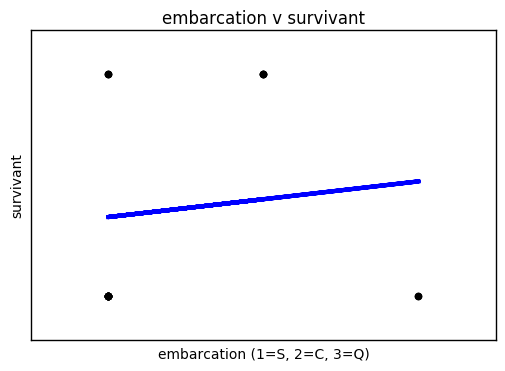

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model



# Split the data into training/testing sets
data_X_train = datap['EmbarkedBin'].to_frame()[:-20]
data_X_test = datap['EmbarkedBin'].to_frame()[-20:]

# Split the targets into training/testing sets
data_y_train = datap['Survived'].to_frame()[:-20]
data_y_test = datap['Survived'].to_frame()[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_X_train, data_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(data_X_test) - data_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(data_X_test, data_y_test))

# Plot outputs
plt.title('embarcation v survivant')
plt.scatter(data_X_test, data_y_test,  color='black')
plt.plot(data_X_test, regr.predict(data_X_test), color='blue',
         linewidth=3)
plt.xlabel('embarcation (1=S, 2=C, 3=Q)')
plt.ylabel('survivant')
plt.xticks(())
plt.yticks(())

plt.show()

In [74]:
print(u'prediction pour embarcation S {px:.2f}'.format(
        px=regr.predict([[1]])[0][0]))
print(u'prediction pour embarcation C {px:.2f}'.format(
        px=regr.predict([[2]])[0][0]))
print(u'prediction pour embarcation Q {px:.2f}'.format(
        px=regr.predict([[3]])[0][0]))

prediction pour embarcation S 0.36
prediction pour embarcation C 0.43
prediction pour embarcation Q 0.51


on peut voir grace là la regression linéaire qu'il y a quand même une légére hausse dans le tarif lorsque l'age devient plus élevé.

ci-dessous des predictions de tarif selon l'âge (grâce à la fonction predict())

In [12]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = datap['AgeFill'].to_frame()
y = datap['Fare'].to_frame()
model.fit(X, y)
print(u'le tarif pour 10 ans doit coûter {px:.2f} $'.format(
        px=model.predict([[10]])[0][0]))
print(u'le tarif pour 22 ans doit coûter {px:.2f} $'.format(
        px=model.predict([[22]])[0][0]))
print(u'le tarif pour 40 ans doit coûter {px:.2f} $'.format(
        px=model.predict([[40]])[0][0]))
print(u'le tarif pour 60 ans doit coûter {px:.2f} $'.format(
        px=model.predict([[60]])[0][0]))
print(u'le tarif pour 80 ans doit coûter {px:.2f} $'.format(
        px=model.predict([[80]])[0][0]))

le tarif pour 10 ans doit coûter 22.91 $
le tarif pour 22 ans doit coûter 28.75 $
le tarif pour 40 ans doit coûter 37.50 $
le tarif pour 60 ans doit coûter 47.23 $
le tarif pour 80 ans doit coûter 56.96 $


<b>Analyse de l'influence du tarif sur la survit</b> 

Ici, on affiche un tableau des tarif selon si survivants ou non

<b>Analyse de l'influence de l'age selon le tarif en prenant en compte les personnes qui ont survecu</b> 

ci-dessous, affichage d'un graphique montrant le nombre de femme survivant et d'homme survivant selon l'age

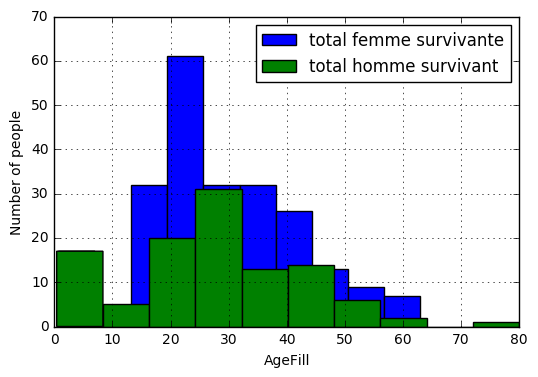

In [13]:
from matplotlib import pyplot

#variable de test
hommesurvivant=(datap['Survived']==1) & (datap['Sex']=='male')
femmesurvivante=(datap['Survived']==1) & (datap['Sex']=='female')

pyplot.hist(datap[femmesurvivante]['AgeFill'], label='total femme survivante')
pyplot.hist(datap[hommesurvivant]['AgeFill'], label='total homme survivant')
pyplot.xlabel('AgeFill')
pyplot.ylabel('Number of people')
pyplot.legend(loc='upper right')
pyplot.grid(True)
pyplot.show()